In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PriorCVAE reimplementation

For a 1D GP, reimplementing all the plots in Liza's 011 notebook.

In [55]:
from jax import random
import jax.numpy as jnp

import time

# Numpyro
import numpyro
from numpyro.infer import MCMC,init_to_median, Predictive

In [56]:
numpyro.set_host_device_count(3)

In [57]:
from reusable.kernels import esq_kernel

args = {
    # GP prior configuration
    "n": 100,
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}
args.update({ # so we can use the definition of n to define x
    
    "x": jnp.arange(0, 1, 1/args["n"]),

    "conditional": True,

    # VAE configuration
    "hidden_dim1": 50,
    "hidden_dim2": 50,
    "latent_dim": 40,

    # learning
    "num_epochs": 500,
    "learning_rate": 1.0e-3,
    "batch_size": 500,
    "train_num_batches": 200,
    "test_num_batches": 2,

    # MCMC parameters
    "num_warmup": 1000,
    "num_samples": 4000,
    "thinning": 1,
    "num_chains": 3,

    "pretrained_vae": False


})

rng_key, _ = random.split(random.PRNGKey(4))

### Examples of priors to encode

Long lengthscales, with ls=0.4

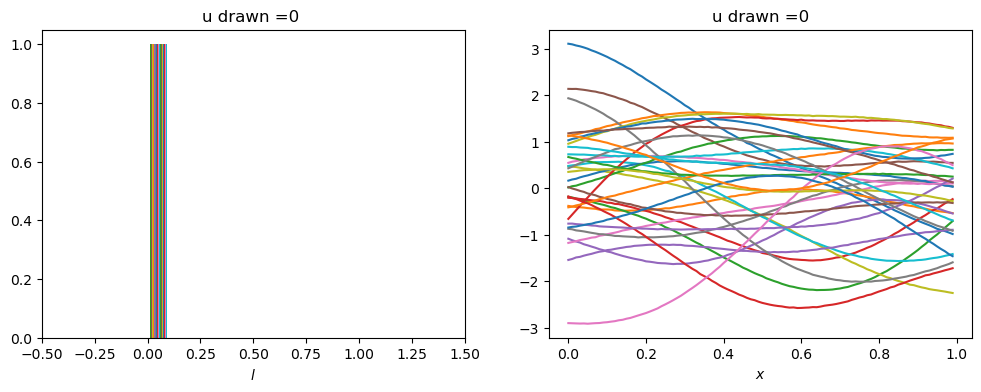

In [58]:
from reusable.gp import OneDGP_BinaryCond
from plotting.plots import plot_lengthscales, plot_draws

rng_key, rng_key_long, rng_key_short, rng_key_both = random.split(rng_key, 4)

long = Predictive(OneDGP_BinaryCond, num_samples=50)
long_samples = long(rng_key_long, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5, u=0)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
plot_lengthscales(long_samples["u"], title="u drawn =0 ", ax=axs[0])
plot_draws(long_samples["y"], args["x"],  title="u drawn =0", ylabel="", ax=axs[1])


Short lengthscales, with ls=0.1

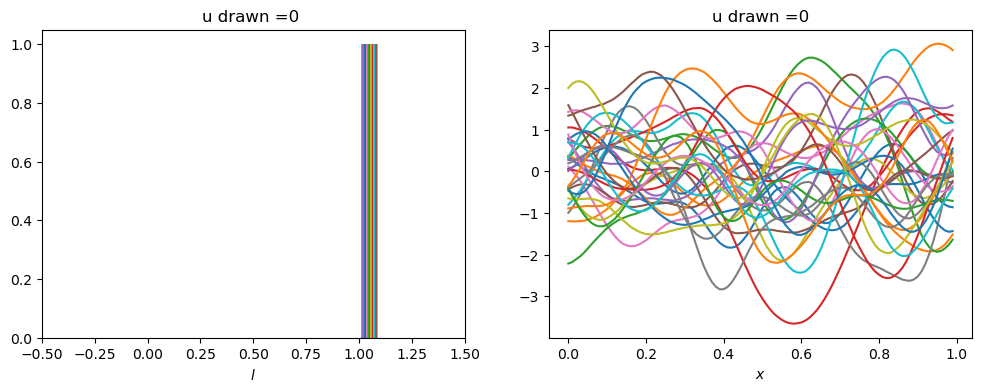

In [59]:

short = Predictive(OneDGP_BinaryCond, num_samples=50)
short_samples = short(rng_key_short, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5, u=1)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
plot_lengthscales(short_samples["u"], title="u drawn =0 ", ax=axs[0])
plot_draws(short_samples["y"], args["x"],  title="u drawn =0", ylabel="", ax=axs[1])

Both lengthscales, together

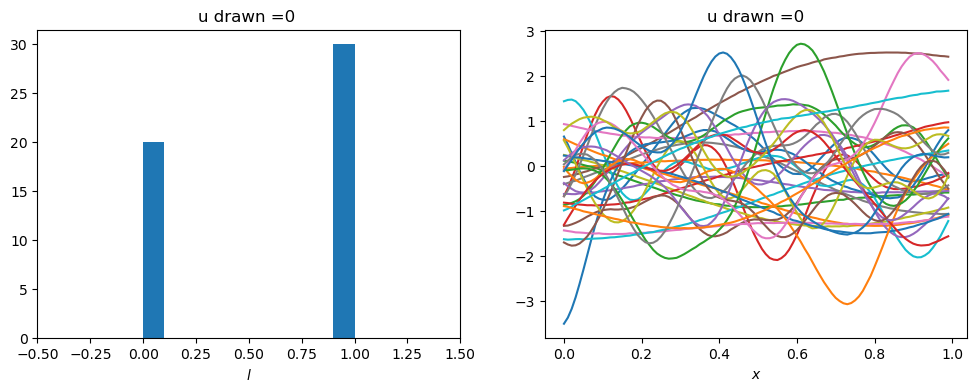

In [60]:
both = Predictive(OneDGP_BinaryCond, num_samples=50)
both_samples = both(rng_key_both, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,4))
plot_lengthscales(both_samples["u"], title="u drawn =0 ", ax=axs[0])
plot_draws(both_samples["y"], args["x"],  title="u drawn =0", ylabel="", ax=axs[1])

Starting, need 100000
Looped: gen 1000/100000 , elapsed: 0.9840865135192871, last batch in 0.9840865135192871
Looped: gen 1000/99000 , elapsed: 1.8821437358856201, last batch in 0.898057222366333
Looped: gen 1000/98000 , elapsed: 3.1186180114746094, last batch in 1.2364742755889893
Looped: gen 1000/97000 , elapsed: 4.60585618019104, last batch in 1.4872381687164307
Looped: gen 1000/96000 , elapsed: 6.091871500015259, last batch in 1.4860153198242188
Looped: gen 1000/95000 , elapsed: 7.351019859313965, last batch in 1.259148359298706
Looped: gen 1000/94000 , elapsed: 9.253560066223145, last batch in 1.9025402069091797
Looped: gen 1000/93000 , elapsed: 10.631916046142578, last batch in 1.3783559799194336
Looped: gen 1000/92000 , elapsed: 11.769275426864624, last batch in 1.137359380722046
Looped: gen 1000/91000 , elapsed: 13.40567660331726, last batch in 1.6364011764526367
Looped: gen 1000/90000 , elapsed: 15.425066709518433, last batch in 2.019390106201172
Looped: gen 1000/89000 , elaps

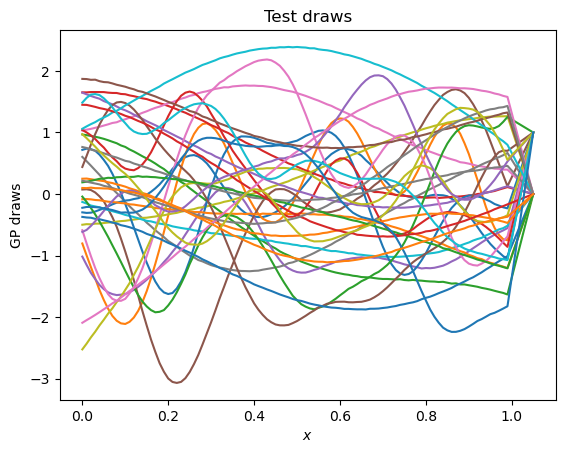

In [61]:
if not args["pretrained_vae"]:
    from reusable.gp import OneDGP_BinaryCond
    from reusable.data import gen_gp_batches

    
    rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)
    # generate a complete set of training and test data

    # NOTE changed draw_access - y_c is [y,u] for this
    train_draws = gen_gp_batches(args["x"], OneDGP_BinaryCond, args["gp_kernel"], args["train_num_batches"], args["batch_size"], rng_key_train, draw_access="y_c")
    test_draws = gen_gp_batches(args["x"], OneDGP_BinaryCond, args["gp_kernel"], 1, args["test_num_batches"]* args["batch_size"], rng_key_test, draw_access="y_c")
    
    from plotting.plots import plot_draws
    print(train_draws[4,1])
    plot_draws(train_draws[4], jnp.append(args["x"], 1.05), "Test draws", "GP draws")

In [62]:
from reusable.vae import VAE
from reusable.train_nn import SimpleTrainState
import optax

rng_key, rng_key_init, rng_key_train = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=True,
)
params = module.init(rng_key, jnp.ones((args["batch_size"], args["n"]+1,)))["params"]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key = rng_key_init)


epoch: 0, test_loss: 0.4874058663845062, train_loss: 0.45931506156921387
epoch: 5, test_loss: 0.3146969676017761, train_loss: 0.3015872836112976
epoch: 10, test_loss: 0.2344062775373459, train_loss: 0.22759437561035156
epoch: 15, test_loss: 0.20184287428855896, train_loss: 0.19694089889526367
epoch: 20, test_loss: 0.20325207710266113, train_loss: 0.1991066038608551
epoch: 25, test_loss: 0.1835358589887619, train_loss: 0.17713433504104614
epoch: 30, test_loss: 0.1824144721031189, train_loss: 0.17642803490161896
epoch: 35, test_loss: 0.18913151323795319, train_loss: 0.1829652190208435
epoch: 40, test_loss: 0.17636466026306152, train_loss: 0.17106962203979492
epoch: 45, test_loss: 0.17731966078281403, train_loss: 0.17191120982170105
epoch: 50, test_loss: 0.17342956364154816, train_loss: 0.1680433452129364
epoch: 55, test_loss: 0.17419572174549103, train_loss: 0.1687096357345581
epoch: 60, test_loss: 0.17467829585075378, train_loss: 0.16916917264461517
epoch: 65, test_loss: 0.1703352034091

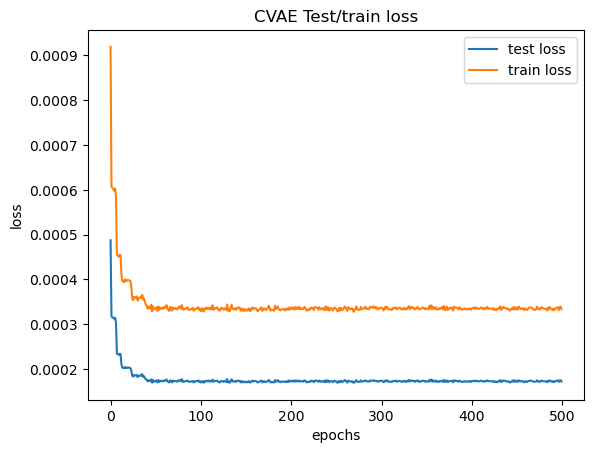

In [63]:
if not args["pretrained_vae"]:
    from reusable.loss import combo_loss, RCL, KLD, conditional_loss_wrapper
    from reusable.train_nn import run_training

    state, metrics_history = run_training(conditional_loss_wrapper(combo_loss(RCL, KLD)), None, args["num_epochs"], train_draws, test_draws, state)

    from plotting.plots import plot_training

    plot_training(metrics_history["test_loss"]/(args["batch_size"] * args["test_num_batches"]), metrics_history["train_loss"]/args["batch_size"], "CVAE Test/train loss", note="loss")


### Training progress

comment 09/02/2023: why is there a shelf in the loss?, also, why is our test loss so closer to train loss?

In [64]:

from reusable.util import gen_file_name, save_training, load_training_state, load_training_history, get_decoder_params


if not args["pretrained_vae"]:
    save_training("03", gen_file_name("03", args), state, metrics_history)


args["pretrained_vae"] = True
if args["pretrained_vae"]:
    state = load_training_state("03", gen_file_name("03", args), state)
    args["decoder_params"] = get_decoder_params(state)

Saved learnt_models/03/03__100_50_50_40_1_500_0.001_500_200__.state
Saved learnt_models/03/03__100_50_50_40_1_500_0.001_500_200__.hist


## Demonstrations

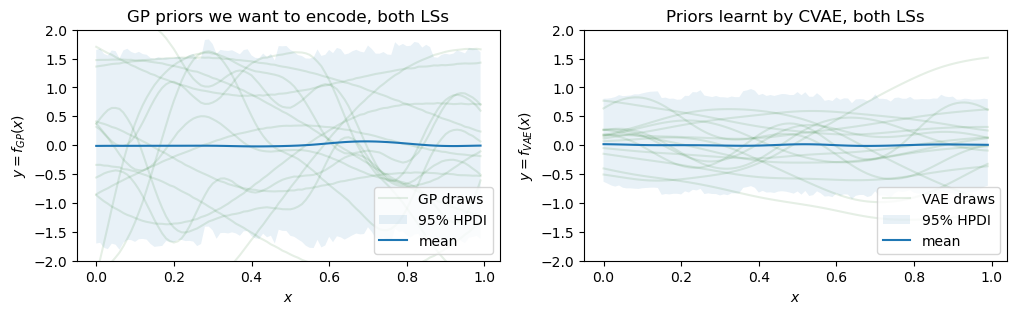

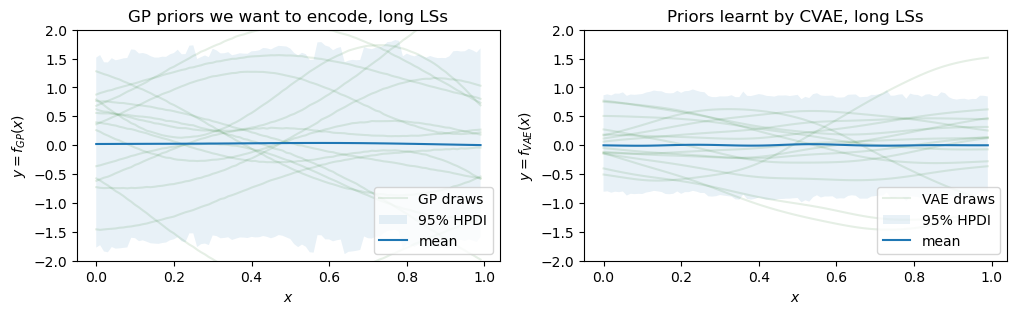

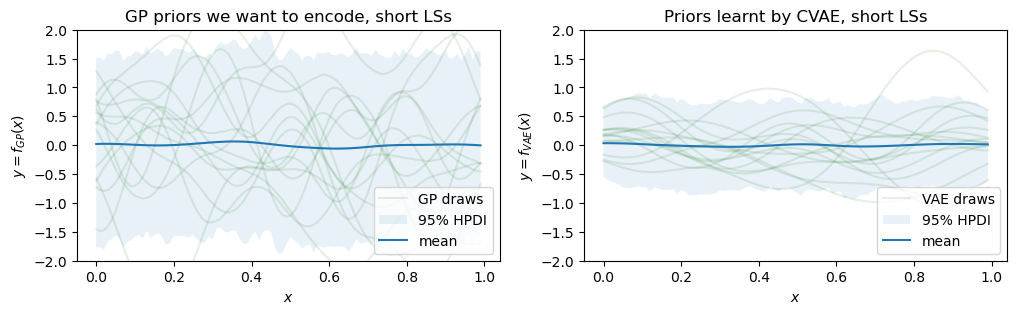

In [65]:
from reusable.vae import cvae_sample
from plotting.plots import compare_draws
rng_key, rng_key_predict = random.split(random.PRNGKey(2))

conditions = [(None, "both"), (0, "long"), (1, "short")]
for cond, label in conditions:

    plot_gp_predictive = Predictive(OneDGP_BinaryCond, num_samples=1000)
    gp_draws = plot_gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5, u=cond)['y']

    plot_vae_predictive = Predictive(cvae_sample, num_samples=1000)
    vae_draws = plot_vae_predictive(
        rng_key_predict,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"],
        condition=cond
    )["f"]

    compare_draws(args["x"], gp_draws, vae_draws, f"GP priors we want to encode, {label} LSs", f"Priors learnt by CVAE, {label} LSs", '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$', "GP", "VAE", save_path="gen_plots/02_prior_comp_both.png")


# Inference

In [66]:
import os
from  numpyro.infer import NUTS
def run_mcmc_cvae(rng_key, model_mcmc, y_obs, obs_idx, c=None, binary_prior=True, verbose=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    #kernel = MixedHMC(kernel)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(
        rng_key,
        args["hidden_dim1"],
        args["hidden_dim2"],
        args["latent_dim"],
        args["n"],
        args["decoder_params"],
        y=y_obs,
        obs_idx=obs_idx,
        c=c,
        binary_prior=binary_prior
    )
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc.get_samples()


Ground truth, c=1

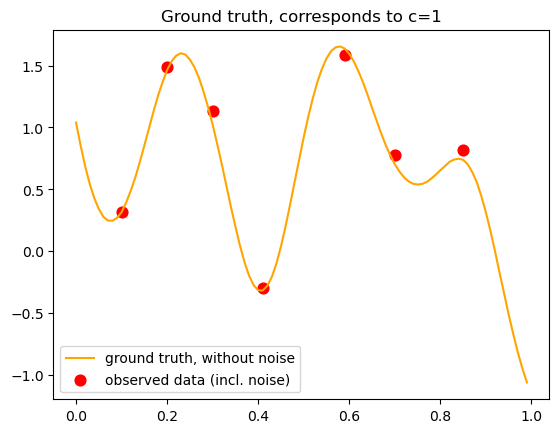

In [67]:
from reusable.gp import OneDGP_BinaryCond
rng_key_ground_truth = random.PRNGKey(
    4
)  # fixed to generate a "ground truth" GP we will try and infer

ground_truth_predictive = Predictive(OneDGP_BinaryCond, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-6, noise=True, u=1
)
ground_truth = gt_draws["f"].T
ground_truth_y_draw = gt_draws["y"].T

obs_idx = jnp.array([10, 20, 30, 41, 59, 70, 85])
gt_y_obs = ground_truth_y_draw[obs_idx, 0]
x_obs = args["x"][obs_idx]

plt.plot(args["x"], ground_truth, label="ground truth, without noise", color="orange")
plt.scatter(x_obs, gt_y_obs, color="red", label="observed data (incl. noise)", s=60)
plt.title('Ground truth, corresponds to c=1')
plt.legend()

## Inference: assume correct LS

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


MCMC elapsed time: 5.652573823928833


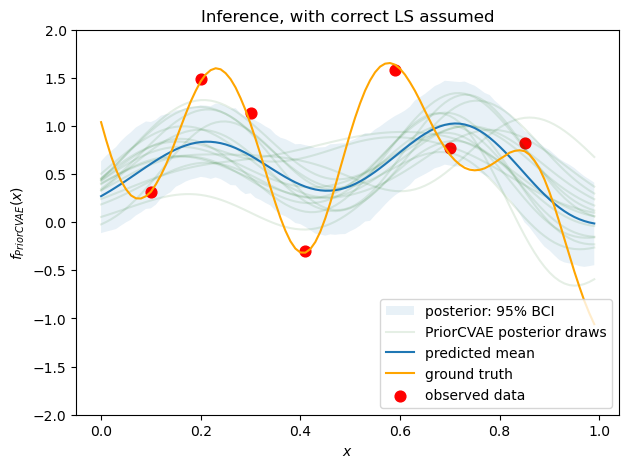

In [68]:
from reusable.mcmc import cvae_mcmc

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_samples = run_mcmc_cvae(rng_key_post, cvae_mcmc, gt_y_obs, obs_idx, c=1)

predictive = Predictive(cvae_mcmc, mcmc_samples)

predictions = predictive(rng_key_pred, hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"], c=1)["f"]

from plotting.plots import plot_one_inference

plot_one_inference(predictions, args["x"], ground_truth, x_obs, gt_y_obs, "Inference, with correct LS assumed", "$f_{PriorCVAE}(x)$", "PriorCVAE")

## Inference: assume wrong LS

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


MCMC elapsed time: 5.370814085006714


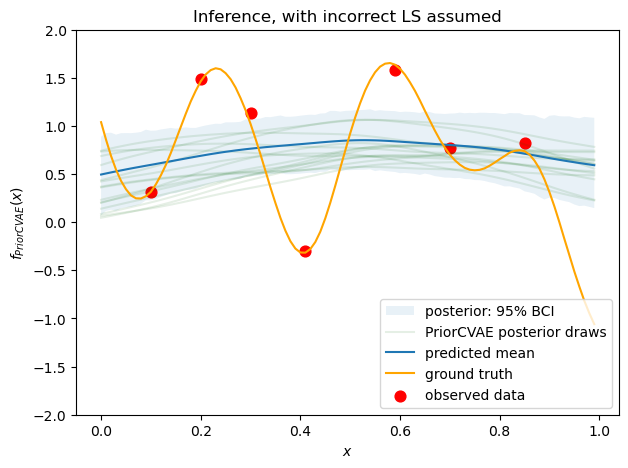

In [69]:
from reusable.mcmc import cvae_mcmc

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_samples = run_mcmc_cvae(rng_key_post, cvae_mcmc, gt_y_obs, obs_idx, c=0)

predictive = Predictive(cvae_mcmc, mcmc_samples)

predictions = predictive(rng_key_pred, hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"], c=0)["f"]

from plotting.plots import plot_one_inference

plot_one_inference(predictions, args["x"], ground_truth, x_obs, gt_y_obs, "Inference, with incorrect LS assumed",  "$f_{PriorCVAE}(x)$", "PriorCVAE")

## Inference: unknown LS (note Beta prior!)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


MCMC elapsed time: 7.662523508071899


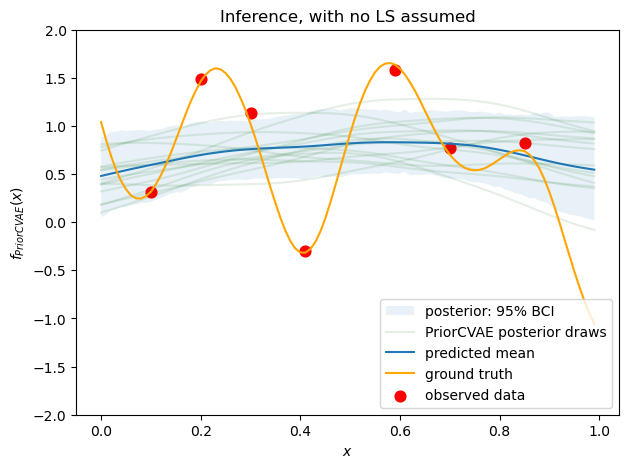

In [70]:
from reusable.mcmc import cvae_mcmc
from plotting.plots import plot_one_inference

rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

mcmc_samples = run_mcmc_cvae(rng_key_post, cvae_mcmc, gt_y_obs, obs_idx, c=None, binary_prior=False)

predictive = Predictive(cvae_mcmc, mcmc_samples)

predictions = predictive(rng_key_pred, hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"], c=None, binary_prior=False)["f"]


plot_one_inference(predictions, args["x"], ground_truth, x_obs, gt_y_obs, "Inference, with no LS assumed",  "$f_{PriorCVAE}(x)$", "PriorCVAE")

# Posterior of lengthscale condition

Text(0.5, 1.0, 'Posterior samples of lengthscale condition')

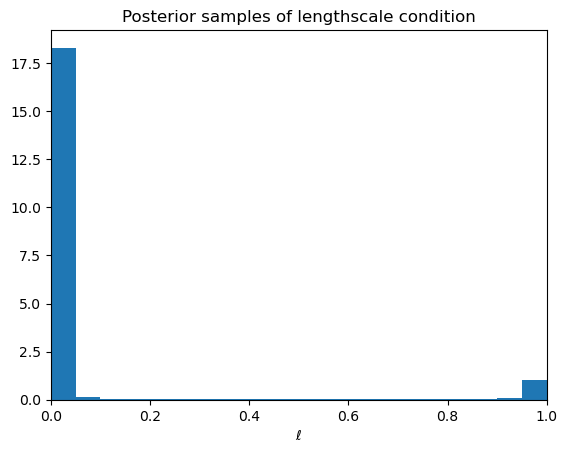

In [71]:
c_samps = mcmc_samples['c']
plt.hist(c_samps, density=True, bins=20) 
plt.xlim(0,1)
plt.xlabel("$\ell$")
plt.title('Posterior samples of lengthscale condition')